In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,StratifiedKFold, cross_validate, RandomizedSearchCV
from sklearn.metrics import classification_report, roc_auc_score,make_scorer, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import label_binarize
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from imblearn.ensemble import BalancedRandomForestClassifier, EasyEnsembleClassifier
from imblearn.pipeline import Pipeline
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import warnings
warnings.filterwarnings("ignore")

# 1. Veri Setinin Yüklenmesi
df = pd.read_csv("df_train_prep.csv")
df["Age"] = df["Age"].apply(lambda x: round(x / 365))
df['NEW_ALBI'] = (0.66 * np.log10(df['Bilirubin'] * 17.104) - 0.085 * df['Albumin'] * 10)
df['NEW_MAYORISKSCORE'] = (0.0394 * (df['Age']) + 0.8707 * np.log(df['Bilirubin']) + 
                                2.380 * np.log(df['Platelets']) +0.8592 * df['Edema'] +2.533 * np.log(df['Albumin'] * 10))

# 2. Özellik ve Hedef Değişkenlerin Ayrılması
X = df.drop("Status", axis=1)  # Özellikler
y = df["Status"]  # Hedef değişken

# 3. Veriyi Train, Test ve Validasyon olarak Bölme
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, stratify=y, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

In [3]:
df

,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,...,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status,NEW_ALBI,NEW_MAYORISKSCORE
0,999,0,59,1,0,0,0,0,2.3,316.0,...,172.0,1601.0,179.80,63.0,394.0,9.7,2,2,-1.794915,26.168274
1,2574,1,53,0,0,0,0,0,0.9,364.0,...,63.0,1440.0,134.85,88.0,361.0,11.0,2,0,-2.225355,25.046473
2,3428,1,38,0,0,1,1,2,3.3,299.0,...,131.0,1029.0,119.35,50.0,199.0,11.7,3,2,-1.861436,25.894840
3,2576,1,51,0,0,0,0,0,0.6,256.0,...,58.0,1653.0,71.30,96.0,269.0,10.7,2,0,-2.307576,23.885734
4,788,1,46,0,0,1,0,0,1.1,346.0,...,63.0,1181.0,125.55,96.0,298.0,10.6,3,0,-2.261336,24.566461
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7900,1166,0,46,0,0,0,0,0,0.8,309.0,...,38.0,1629.0,79.05,224.0,344.0,9.9,1,0,-2.276116,24.567588
7901,1492,1,47,0,0,1,0,0,0.9,260.0,...,62.0,1440.0,142.00,78.0,277.0,10.0,3,0,-2.131855,24.099747
7902,1576,0,71,0,0,0,1,1,2.0,225.0,...,51.0,933.0,69.75,62.0,200.0,12.7,1,2,-1.698976,25.640900
7903,3584,0,63,1,0,1,0,0,0.7,248.0,...,32.0,1003.0,57.35,118.0,221.0,10.6,3,2,-1.625891,23.414104


In [4]:
# 4. Base Modelleri Tanımlama
models = {
    "Random Forest": BalancedRandomForestClassifier(random_state=42),
    "Easy Ensemble": EasyEnsembleClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
    "LightGBM": LGBMClassifier(force_col_wise=True, random_state=42)
}


In [5]:
# 5. Çapraz Doğrulama Sonuçlarının Depolanması
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = {
    'accuracy': 'accuracy',
    'f1_macro': 'f1_macro',
    'roc_auc_ovr': make_scorer(roc_auc_score, needs_proba=True, average='macro', multi_class='ovr')
}
cv_results_summary = []

In [6]:
for name, model in models.items():
    # RandomOverSampler'ı tanımla
    oversampler = RandomOverSampler(random_state=42)
    
    # Oversampling işlemini uygula
    X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)
    
    # Oversampled verilerin boyutlarını ve sınıf dağılımını yazdır
    print(f"\nModel: {name}")
    print("Oversampled X_train shape:", X_train_resampled.shape)
    print("Oversampled y_train shape:", y_train_resampled.shape)
    print("Original class distribution:", Counter(y_train))
    print("Oversampled class distribution:", Counter(y_train_resampled))
    
    pipeline = Pipeline([
        ('oversampler', RandomOverSampler(random_state=42)),
        ('model', model)
    ])
    cv_results = cross_validate(pipeline, X_train, y_train, cv=cv, scoring=scoring)
    cv_results_summary.append({
        "Model": name,
        "Accuracy": np.mean(cv_results['test_accuracy']),
        "F1 Macro": np.mean(cv_results['test_f1_macro']),
        "ROC AUC": np.mean(cv_results['test_roc_auc_ovr'])
    })

cv_results_df = pd.DataFrame(cv_results_summary)


Model: Random Forest
Oversampled X_train shape: (8937, 20)
Oversampled y_train shape: (8937,)
Original class distribution: Counter({0: 2979, 2: 1599, 1: 165})
Oversampled class distribution: Counter({2: 2979, 0: 2979, 1: 2979})

Model: Easy Ensemble
Oversampled X_train shape: (8937, 20)
Oversampled y_train shape: (8937,)
Original class distribution: Counter({0: 2979, 2: 1599, 1: 165})
Oversampled class distribution: Counter({2: 2979, 0: 2979, 1: 2979})

Model: XGBoost
Oversampled X_train shape: (8937, 20)
Oversampled y_train shape: (8937,)
Original class distribution: Counter({0: 2979, 2: 1599, 1: 165})
Oversampled class distribution: Counter({2: 2979, 0: 2979, 1: 2979})

Model: LightGBM
Oversampled X_train shape: (8937, 20)
Oversampled y_train shape: (8937,)
Original class distribution: Counter({0: 2979, 2: 1599, 1: 165})
Oversampled class distribution: Counter({2: 2979, 0: 2979, 1: 2979})
[LightGBM] [Info] Total Bins 2217
[LightGBM] [Info] Number of data points in the train set: 714

In [7]:
cv_results_df

,Model,Accuracy,F1 Macro,ROC AUC
0,Random Forest,0.814255,0.625358,0.864922
1,Easy Ensemble,0.718742,0.575045,0.848143
2,XGBoost,0.814674,0.630651,0.869763
3,LightGBM,0.812568,0.639744,0.873289


In [8]:
# 6. Test Verisi Üzerinde Performans Değerlendirmesi
initial_test_results = []

for name, model in models.items():
    pipeline = Pipeline([
        ('oversampler', RandomOverSampler(random_state=42)),
        ('model', model)
    ])
    pipeline.fit(X_train, y_train)
    y_test_pred = pipeline.predict(X_test)
    y_test_binarized = label_binarize(y_test, classes=[0, 1, 2])
    roc_auc = roc_auc_score(y_test_binarized, pipeline.predict_proba(X_test), average="macro", multi_class="ovr")
    f1_macro = classification_report(y_test, y_test_pred, output_dict=True)['macro avg']['f1-score']
    initial_test_results.append({
        "Model": name,
        "F1 Macro": f1_macro,
        "ROC AUC": roc_auc
    })

initial_test_results_df = pd.DataFrame(initial_test_results)

[LightGBM] [Info] Total Bins 2252
[LightGBM] [Info] Number of data points in the train set: 8937, number of used features: 20
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


In [9]:
initial_test_results_df

,Model,F1 Macro,ROC AUC
0,Random Forest,0.610111,0.869294
1,Easy Ensemble,0.549522,0.830596
2,XGBoost,0.629649,0.852436
3,LightGBM,0.632730,0.860771


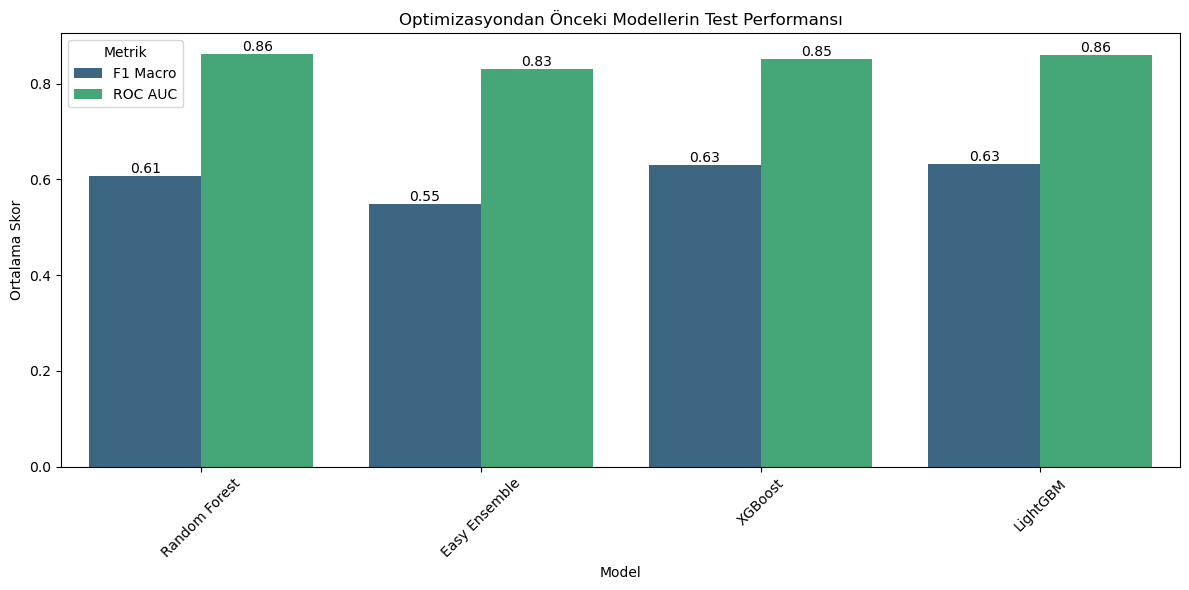

In [8]:
# Görselleştirme Fonksiyonu
def plot_scores(data, title):
    melted_data = data.melt(id_vars="Model", var_name="Metric", value_name="Score")
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(data=melted_data, x="Model", y="Score", hue="Metric", palette="viridis")
    
    for p in ax.patches:
        ax.annotate(f"{p.get_height():.2f}", 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='bottom', fontsize=10, color='black')
    
    plt.title(title)
    plt.ylabel("Ortalama Skor")
    plt.xticks(rotation=45)
    plt.legend(title="Metrik")
    plt.tight_layout()
    plt.show()

# Optimizasyondan önceki sonuçları görselleştir
plot_scores(initial_test_results_df, "Optimizasyondan Önceki Modellerin Test Performansı")

In [9]:
# 7. Hiperparametre Optimizasyonu
param_grids = {
    "Random Forest": {
        'model__n_estimators': [100, 300, 400],
        'model__max_depth': [None, 5, 7],
        'model__max_features': [5, 7, 'auto'],
        'model__min_samples_split': [10, 20, 30],
    },
    "Easy Ensemble": {
        'model__n_estimators': [None, 3, 5],
    },
    "XGBoost": {
        'model__learning_rate': [0.1, 0.5, 0.8],
        'model__max_depth': [None, 3, 10],
        'model__n_estimators': [50, 100, 200],
        'model__subsample': [0.01, 0.1, 0.5],
    },
    "LightGBM": {
        'model__learning_rate': [0.01, 0.1],
        'model__n_estimators': [300, 500],
        'model__colsample_bytree': [0.7, 1]
    }
}


Random Forest modeli optimize ediliyor...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Easy Ensemble modeli optimize ediliyor...
Fitting 5 folds for each of 3 candidates, totalling 15 fits
XGBoost modeli optimize ediliyor...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
LightGBM modeli optimize ediliyor...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[LightGBM] [Info] Total Bins 2254
[LightGBM] [Info] Number of data points in the train set: 8937, number of used features: 21
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
En iyi hiperparametre sonuçları:
           Model                                        Best Params  \
0  Random Forest  {'model__n_estimators': 300, 'model__min_sampl...   
1  Easy Ensemble                         {'model__n_estimators': 3}   
2        XGBoost  {'model__subsample': 0.1, 'model__n_estimators...

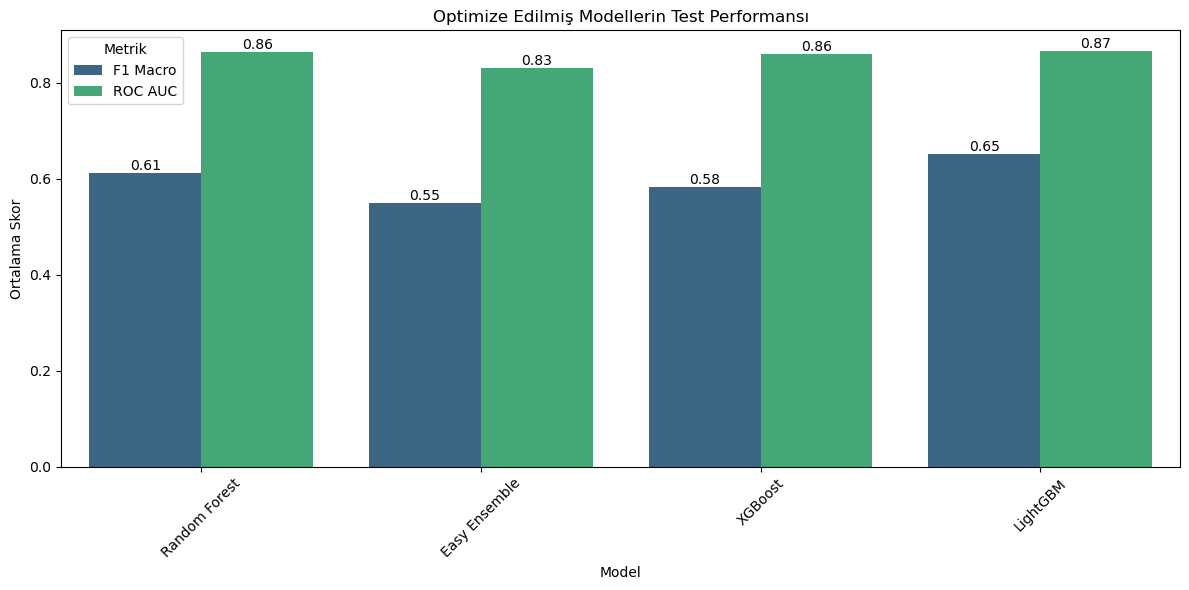

Random Forest - Confusion Matrix ve Metrikler


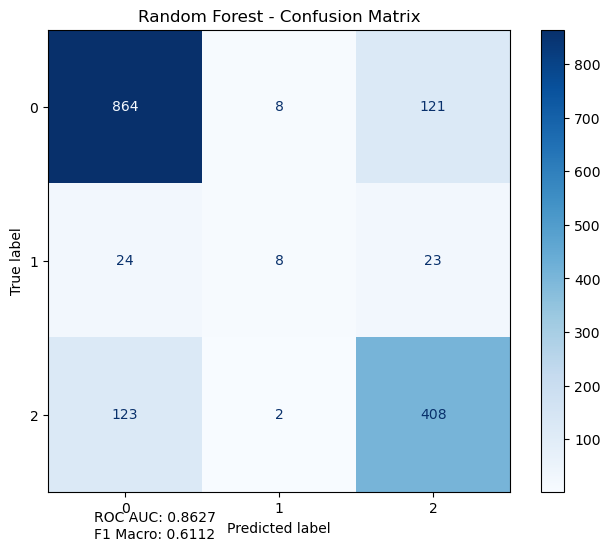

Easy Ensemble - Confusion Matrix ve Metrikler


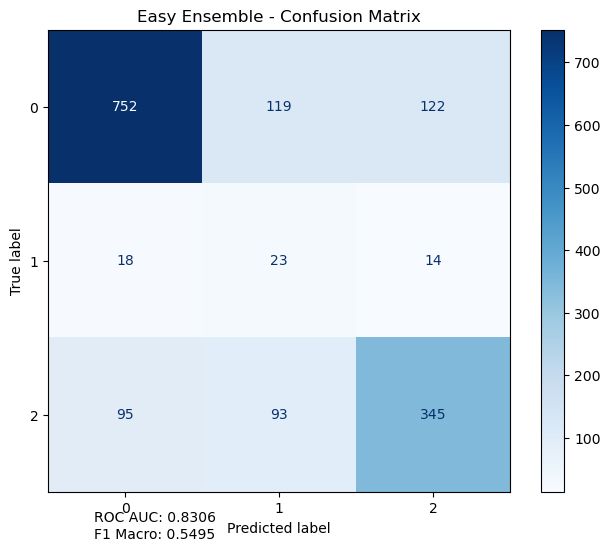

XGBoost - Confusion Matrix ve Metrikler


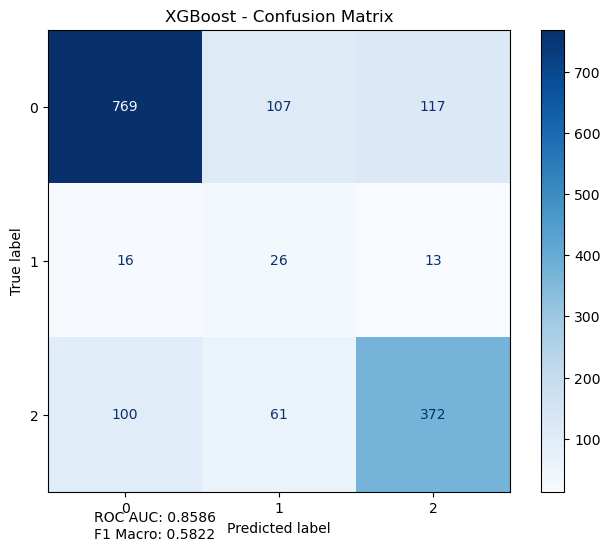

LightGBM - Confusion Matrix ve Metrikler


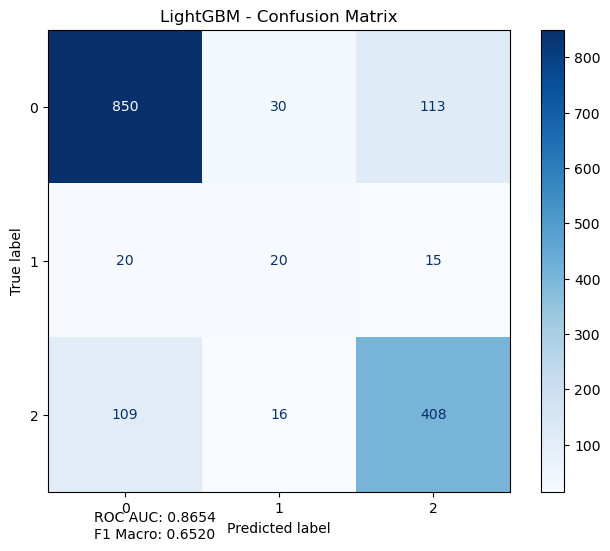

In [10]:
optimized_models = {}
optimization_results = []

for name, model in models.items():
    print(f"{name} modeli optimize ediliyor...")
    pipeline = Pipeline([
        ('oversampler', RandomOverSampler(random_state=42)),
        ('model', model)
    ])

    param_grid = param_grids[name]
    search = RandomizedSearchCV(
        estimator=pipeline,
        param_distributions=param_grid,
        scoring=make_scorer(roc_auc_score, needs_proba=True, average='macro', multi_class='ovr'),
        n_iter=10,
        cv=5,
        verbose=1,
        random_state=42,
        n_jobs=-1
    )

    search.fit(X_train, y_train)
    
    optimized_models[name] = search.best_estimator_
    optimization_results.append({
        "Model": name,
        "Best Params": search.best_params_,
        "Best ROC AUC": search.best_score_
    })

optimization_results_df = pd.DataFrame(optimization_results)

print("En iyi hiperparametre sonuçları:")
print(optimization_results_df)

# 8. Optimizasyondan Sonraki Performans
final_test_results = []

for name, optimized_model in optimized_models.items():
    y_test_pred = optimized_model.predict(X_test)
    y_test_binarized = label_binarize(y_test, classes=[0, 1, 2])
    roc_auc = roc_auc_score(y_test_binarized, optimized_model.predict_proba(X_test), average="macro", multi_class="ovr")
    f1_macro = classification_report(y_test, y_test_pred, output_dict=True)['macro avg']['f1-score']
    final_test_results.append({
        "Model": name,
        "F1 Macro": f1_macro,
        "ROC AUC": roc_auc
    })

final_test_results_df = pd.DataFrame(final_test_results)

# Optimizasyondan sonra sonuçları görselleştir
plot_scores(final_test_results_df, "Optimize Edilmiş Modellerin Test Performansı")

def plot_confusion_matrix_with_metrics(y_true, y_pred, model_name, classes, metrics):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    
    # Confusion matrix çizimi
    fig, ax = plt.subplots(figsize=(8, 6))
    disp.plot(cmap='Blues', ax=ax, values_format='d')
    
    # Metrikleri ekleme
    metrics_text = "\n".join([f"{key}: {value:.4f}" for key, value in metrics.items()])
    plt.gcf().text(0.1, -0.1, metrics_text, fontsize=10, ha='left', transform=ax.transAxes)
    
    plt.title(f"{model_name} - Confusion Matrix")
    plt.show()

# Modeller için confusion matrix ve metrik yazdırma
classes = [0, 1, 2]  # Sınıflarınızı belirtin (örneğin, [0, 1, 2])
for name, optimized_model in optimized_models.items():
    y_test_pred = optimized_model.predict(X_test)
    y_test_binarized = label_binarize(y_test, classes=classes)
    
    # Değerlendirme metriklerini hesapla
    roc_auc = roc_auc_score(y_test_binarized, optimized_model.predict_proba(X_test), average="macro", multi_class="ovr")
    f1_macro = classification_report(y_test, y_test_pred, output_dict=True)['macro avg']['f1-score']
    
    metrics = {
        "ROC AUC": roc_auc,
        "F1 Macro": f1_macro
    }
    
    print(f"{name} - Confusion Matrix ve Metrikler")
    plot_confusion_matrix_with_metrics(y_test, y_test_pred, name, classes, metrics)

Random Forest - Özellik Önemi Grafiği:


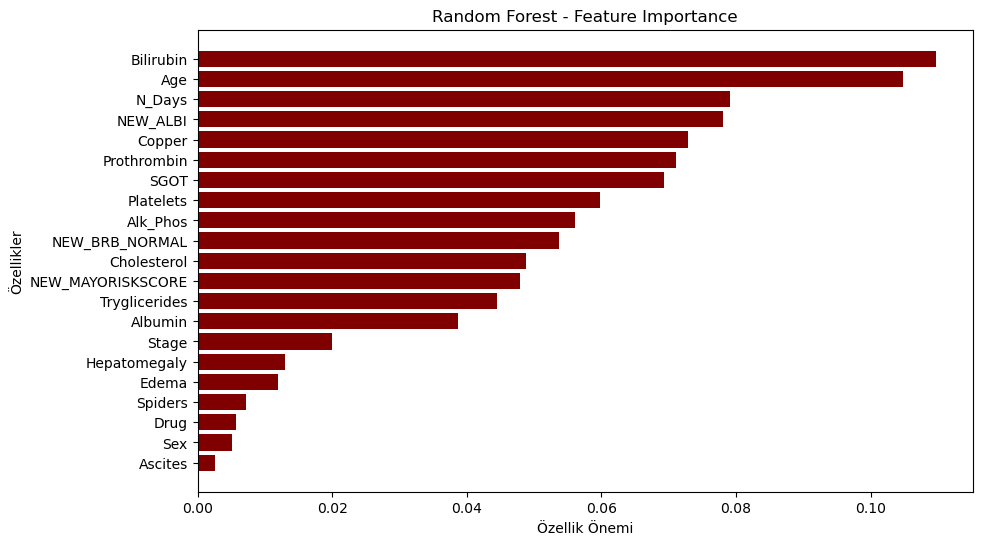

Easy Ensemble - Özellik Önemi Grafiği:
Easy Ensemble modeli feature importance desteklemiyor.
XGBoost - Özellik Önemi Grafiği:


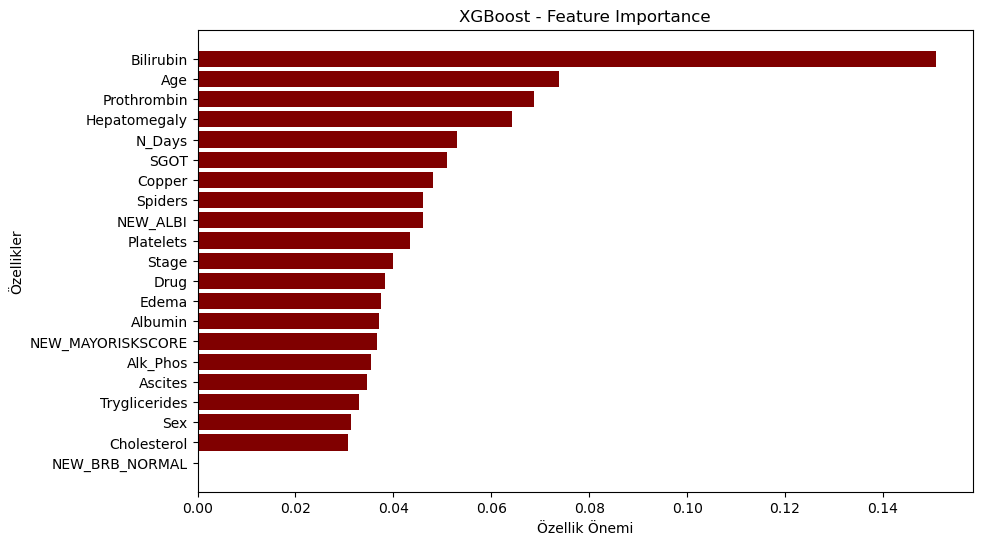

LightGBM - Özellik Önemi Grafiği:


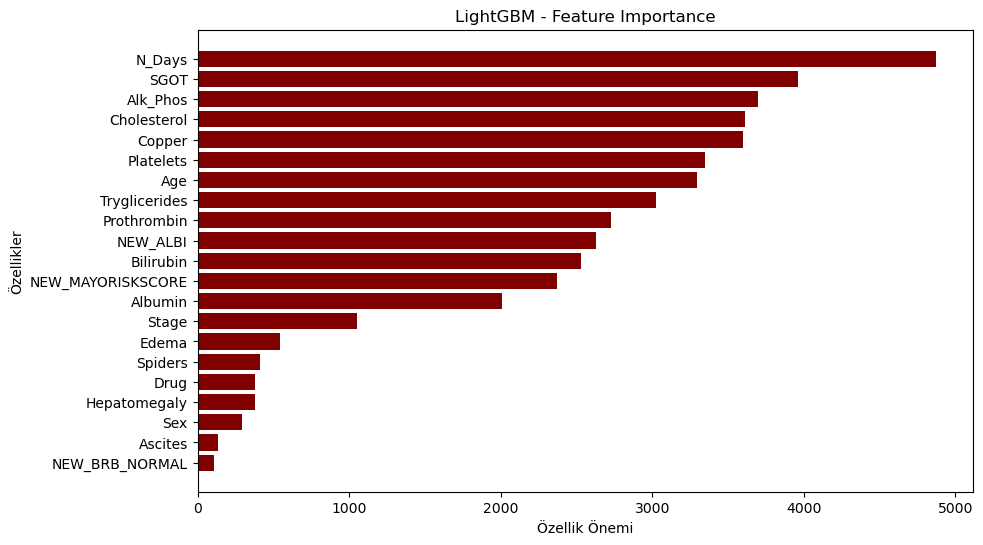

In [11]:
import matplotlib.pyplot as plt
import numpy as np

def plot_feature_importance(model, feature_names, model_name):
    """
    Özellik önemini çizer.
    """
    if hasattr(model, 'feature_importances_'):
        importance = model.feature_importances_
    elif hasattr(model, 'coef_'):
        importance = np.abs(model.coef_[0])  # Lojistik regresyon gibi lineer modeller için
    else:
        print(f"{model_name} modeli feature importance desteklemiyor.")
        return

    # Özellik önemlerini sırala
    sorted_idx = np.argsort(importance)[::-1]
    sorted_features = [feature_names[i] for i in sorted_idx]
    sorted_importance = importance[sorted_idx]

    # Çizim
    plt.figure(figsize=(10, 6))
    plt.barh(sorted_features, sorted_importance, color='maroon')
    plt.gca().invert_yaxis()  # En önemli özellik yukarıda görünsün
    plt.xlabel("Özellik Önemi")
    plt.ylabel("Özellikler")
    plt.title(f"{model_name} - Feature Importance")
    plt.show()

# Özellik önemi grafiği için ekleme
feature_names = X_train.columns  # X_train bir DataFrame ise, kolon isimlerini kullanıyoruz

for name, optimized_model in optimized_models.items():
    print(f"{name} - Özellik Önemi Grafiği:")
    # Pipeline'dan asıl modeli çıkar
    model = optimized_model.named_steps['model']
    plot_feature_importance(model, feature_names, name)
